# Deep Learning approach to the Titanic problem

In [1]:
%env PYTHONHASHSEED=0

import os
DEVMODE = os.getenv("KAGGLE_MODE") == "DEV"
print(f"DEV MODE: {DEVMODE}")

# Define seed to reprodicibility of random generation
SEED = 42
DEV_SPLIT=0.2

env: PYTHONHASHSEED=0
DEV MODE: True


In [2]:
import importlib
if importlib.util.find_spec("comet_ml"):
    from comet_ml import Experiment
    experiment = Experiment(project_name="titanic")
else:
    experiment = None

COMET INFO: old comet version (3.1.9) detected. current: 3.1.12 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/witalia008/titanic/d56364a7269d45bd86fdd71b091aaa61



In [3]:
import numpy as np
import pandas as pd

# To display all the columns from left to right without breaking into next line.
pd.set_option("display.width", 1500)
pd.plotting.register_matplotlib_converters()

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.2.0


In [4]:
import random as python_random

# Make sure Keras produces reproducible results.

np.random.seed(SEED)
python_random.seed(SEED)
tf.random.set_seed(SEED)

In [5]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print(physical_devices)
for device in (physical_devices or []):
    tf.config.experimental.set_memory_growth(device, True)

[]


# Read data and extract usable features

In [6]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv", index_col="PassengerId")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv", index_col="PassengerId")

In [7]:
features = "Pclass Sex SibSp Parch Fare Embarked Name Cabin Age".split()

X_train_init = train_data[features]
Y_train_init = train_data.Survived

print(X_train_init.shape)
print(Y_train_init.shape)

X_test_init = test_data[features]

print(X_test_init.shape)

(891, 9)
(891,)
(418, 9)


# Split into train/dev sets
## Needs to be done before pre-processing to avoid test-train contamination

In [8]:
from sklearn.model_selection import train_test_split

X_train_unproc, X_dev_unproc, Y_train_unproc, Y_dev_unproc = train_test_split(X_train_init, Y_train_init, test_size=DEV_SPLIT, random_state=SEED)

print(X_train_unproc.shape, Y_train_unproc.shape)
print(X_dev_unproc.shape, Y_dev_unproc.shape)

(712, 9) (712,)
(179, 9) (179,)


In [9]:
def prepare_data(X):
    import re

    important_titles = ["Mr", "Mrs", "Miss", "Master"]
    
    X = X.copy()
    
    # Remember missing values
    for col in "Age".split():
        X[f"{col}_Missing"] = np.where(X[col].isnull(), 1, 0)
        
    if "Parch" in X and "SibSp" in X:
        X["Family"] = X.Parch + X.SibSp

    if "Fare" in X:
        X.Fare = X.Fare.fillna(X.Fare.mean())
        # TODO: See if can transform using 'log' or something like that
        X.Fare = pd.cut(X.Fare, bins=[-1, 15, 30, 50, 70, 100, 600], labels=False) + 1

    if "Embarked" in X:
        X.Embarked = X.Embarked.fillna(X.Embarked.mode()[0])
        X.Embarked = X.Embarked.astype(pd.api.types.CategoricalDtype(categories="C Q S".split()))

    if "Name" in X:
        X["Title"] = X.Name.apply(lambda name: re.search(", ([\w ]+).", name).group(1))

        X.Title = X.Title.apply(lambda title: title if title in important_titles else "Others")

    if "Age" in X:
        # TODO: Maybe mean should always be taken from the train set?
        X["Age"] = X.groupby("Pclass Sex".split())["Age"].transform(lambda x: x.fillna(x.mean()))
        X.Age = pd.cut(X.Age, bins=[0, 16, 30, 50, 80], labels=False) + 1
        
    X = X.drop(columns="Name Cabin Parch SibSp".split())
        
    X = pd.get_dummies(X, columns="Sex Embarked Title".split())

    # TODO: Standardize features for the neural network - maybe use StandardScaler
    
    # TODO: Select better features to use for the model.
    
    return X

In [10]:
print("Train data:")
X_train = prepare_data(X_train_unproc)
Y_train = Y_train_unproc
print(X_train.head())

print("Dev data:")
X_dev = prepare_data(X_dev_unproc)
Y_dev = Y_dev_unproc
print(X_dev.head())

print("Test data:")
X_test = prepare_data(X_test_init)
print(X_test.head())

Train data:
             Pclass  Fare  Age  Age_Missing  Family  Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  Title_Master  Title_Miss  Title_Mr  Title_Mrs  Title_Others
PassengerId                                                                                                                                                               
332               1     2    3            0       0           0         1           0           0           1             0           0         1          0             0
734               2     1    2            0       0           0         1           0           0           1             0           0         1          0             0
383               3     1    3            0       0           0         1           0           0           1             0           0         1          0             0
705               3     1    2            0       1           0         1           0           0           1             0          

# DL model using Keras

In [11]:
METRICS = [
      keras.metrics.TruePositives(name="tp"),
      keras.metrics.FalsePositives(name="fp"),
      keras.metrics.TrueNegatives(name="tn"),
      keras.metrics.FalseNegatives(name="fn"),
      keras.metrics.BinaryAccuracy(name="accuracy"),
      keras.metrics.Precision(name="precision"),
      keras.metrics.Recall(name="recall"),
      keras.metrics.AUC(name="auc"),
]

def get_model(input_size):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.regularizers import l2

    model = Sequential([
        Dense(128, input_shape=(input_size,), activation="relu", kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), kernel_initializer="he_uniform"),
        Dropout(0.2),
        Dense(32, activation="relu", kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), kernel_initializer="he_uniform"),
        Dropout(0.2),
        Dense(20, activation="relu", kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), kernel_initializer="he_uniform"),
        Dropout(0.25),
        Dense(6, activation="tanh", kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), kernel_initializer="glorot_uniform"),
        Dropout(0.3),
        Dense(1, activation="sigmoid")
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(1e-3), metrics=METRICS, loss="binary_crossentropy")
    
    return model

In [12]:
died_cnt, survived_cnt = np.bincount(Y_train_init)
total_cnt = died_cnt + survived_cnt

weight_died = total_cnt / died_cnt / 2
weight_survived = total_cnt / survived_cnt / 2

class_weights = {0: weight_died, 1: weight_survived}

In [13]:
# Create a new model each time before running training (otherwise new trainings would just be on already trained model)
model = get_model(X_train.shape[1])

# TODO: See how can make less verbose.
history = model.fit(X_train, Y_train, epochs=500, batch_size=32, validation_data=(X_dev, Y_dev), class_weight=class_weights)

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE
Epoch 1/500
23/23 [==============================] - 3s 113ms/step - loss: 4.2285 - tp: 47.0000 - fp: 87.0000 - tn: 357.0000 - fn: 221.0000 - accuracy: 0.5674 - precision: 0.3507 - recall: 0.1754 - auc: 0.4914 - val_loss: 3.8278 - val_tp: 34.0000 - val_fp: 12.0000 - val_tn: 93.0000 - val_fn: 40.0000 - val_accuracy: 0.7095 - val_precision: 0.7391 - val_recall: 0.4595 - val_auc: 0.7008
Epoch 2/500
23/23 [==============================] - 0s 16ms/step - loss: 3.7530 - tp: 139.0000 - fp: 183.0000 - tn: 261.0000 - fn: 129.0000 - accuracy: 0.5618 - precision: 0.4317 - recall: 0.5187 - auc: 0.5664 - val_loss: 3.5026 - val_tp: 63.0000 - val_fp: 45.0000 - val_tn: 60.0000 - val_fn: 11.0000 - val_accuracy: 0.6872 - val_precision: 0.5833 - val_recall: 0.8514 - val_auc: 0.7844
Epoch 3/500
23/23 [==============================] - 0s 19ms/step - loss: 3.4336 - tp: 140.0000 - fp: 164.0

# Results of the DL model

In [14]:
def plot_model_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()

dict_keys(['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


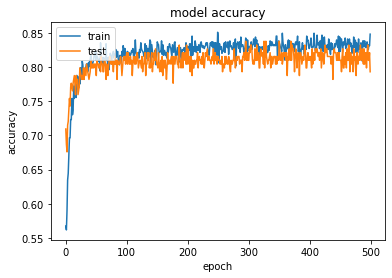

In [15]:
plot_model_history(history)

In [16]:
def draw_confusion_matrix(evaluation_result, label):
    # TP FP
    # FN TN
    matrix = np.round(np.array([[evaluation_result[1], evaluation_result[2]], [evaluation_result[4], evaluation_result[3]]]))
    
    plt.figure(figsize=(4,3))
    
    ax = sns.heatmap(data=matrix, annot=True, fmt=".0f")
    ax.invert_yaxis()
    ax.invert_xaxis()
    
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(f"Confusion matrix for {label}")

Train evaluation:
23/23 - 0s - loss: 0.4661 - tp: 216.0000 - fp: 76.0000 - tn: 368.0000 - fn: 52.0000 - accuracy: 0.8202 - precision: 0.7397 - recall: 0.8060 - auc: 0.8808


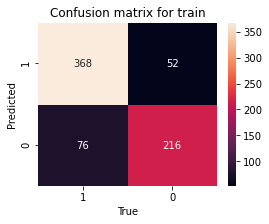

In [17]:
print("Train evaluation:")
evaluation_train = model.evaluate(X_train, Y_train, verbose=2)
draw_confusion_matrix(evaluation_train, "train")

Dev evaluation:
6/6 - 0s - loss: 0.5088 - tp: 62.0000 - fp: 25.0000 - tn: 80.0000 - fn: 12.0000 - accuracy: 0.7933 - precision: 0.7126 - recall: 0.8378 - auc: 0.8929


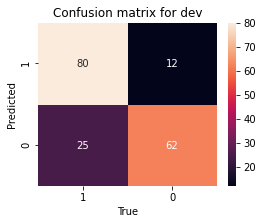

In [18]:
print("Dev evaluation:")
evaluation_dev = model.evaluate(X_dev, Y_dev, verbose=2)
draw_confusion_matrix(evaluation_dev, "dev")

# Predict with DL model

In [19]:
def store_predictions(model, submission_name):
    predictions = model.predict(X_test)

    predictions = np.round(predictions).astype(np.uint8).reshape((-1))

    print(f"{submission_name}:\n{predictions}")
    
    output = pd.DataFrame({"Survived": predictions}, index=test_data.index)
    output.to_csv(f"/kaggle/working/{submission_name}.csv", index=True)

In [20]:
store_predictions(model, "dl_submission")

dl_submission:
[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 1 0 1
 1 0 1 0 0 0 1 1 0 1 0 1 1 0 1 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1
 1 1 0 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 0 0 0 1 1 0 1 1 1 1 0 1 0
 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0
 1 0 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0
 1 0 1 0 0 1 1 0 0 0 1 1 1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0 0 1 0 1 1 0 0 0
 1 1 0 1 1 1 0 1 0 0 1]


In [21]:
if experiment:
    experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/witalia008/titanic/d56364a7269d45bd86fdd71b091aaa61
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [500]                 : (0.5617977380752563, 0.851123571395874)
COMET INFO:     auc [500]                      : (0.4914490282535553, 0.8860595226287842)
COMET INFO:     batch_accuracy [1500]          : (0.4375, 1.0)
COMET INFO:     batch_auc [1500]               : (0.3481781482696533, 1.0)
COMET INFO:     batch_fn [1500]                : (0.0, 210.0)
COMET INFO:     batch_fp [1500]                : (0.0, 173.0)
COMET INFO:     batch_loss [1500]              : (0.2622811198234558, 4.647127628326416)
COMET INFO:     batch_precision [1500]         : (0.0, 1.0)
COMET INFO:     batch_recall [1500]            : (0.0, 1.0)
COMET INFO:  